In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

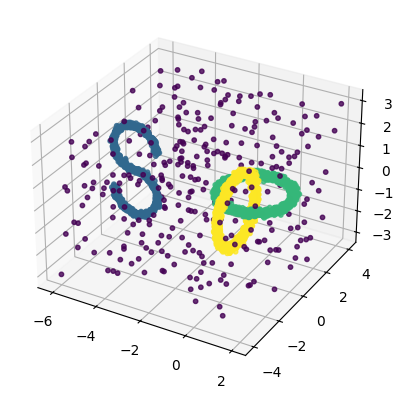

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from clustpy.utils import plot_3d_data
from sklearn.datasets import make_s_curve, make_circles

def create_multiple_shapes(clusters_sizes=1000, seed=1, spread=0.2):
    random_state = np.random.RandomState(seed)

    # Add S-curve
    X_curve, _ = make_s_curve(clusters_sizes, random_state=random_state, noise=spread / 4)
    # Change width of non-S dimension
    X_curve[:, 1] = (
        (X_curve[:, 1] - np.min(X_curve[:, 1]))
        / (np.max(X_curve[:, 1]) - np.min(X_curve[:, 1]))
        * spread
        + spread / 2
        + 1.5
    )
    X_curve[:, 1] += -1.7
    X_curve[:, 0] -= 5

    # Add two circles
    X_circle1, L_circle1 = make_circles(
        2 * clusters_sizes, noise=spread / 4, random_state=random_state
    )
    X_circle1 = X_circle1[L_circle1 == 0]
    # Create second circle that can later be rotated
    X_circle2 = X_circle1.copy()
    # Add third dimension to first circle
    X_circle1 = np.c_[
        X_circle1, random_state.random(clusters_sizes).reshape(-1, 1) * spread - spread / 2
    ]
    # Add third dimension (at first position) to second circle -> rotated version of first circle
    X_circle2 = np.c_[
        random_state.random(clusters_sizes).reshape(-1, 1) * spread - spread / 2, X_circle2
    ]
    # Move second circle to center of first circle
    X_circle2[:, 1] -= 1
    X_circles = np.r_[X_circle1, X_circle2]
    # Move circles to correct position next to the S-curve
    # X_circles[:, 1] += 1
    X_circles[:, 1] += 0.5
    X_circles *= 1.5

    # Add blob
    # X_blob = random_state.multivariate_normal(mean=[0.5, 0, 0], cov=[[spread/4, 0, 0], [0, spread/4, 0], [0, 0, spread/4]],
    #                                           size=clusters_sizes)

    # Combine data arrays
    X = np.r_[X_curve, X_circles]  # , X_blob]

    # Create labels array
    l = np.zeros(3 * clusters_sizes)
    for i in range(1, 3):
        l[i * clusters_sizes : (i + 1) * clusters_sizes] = i

    return X, l

from src.utils.data import add_noise

X, l = create_multiple_shapes()

np.random.seed(10)
X = np.r_[X, [[2,4,3],[-6,-4,-3]]]
l = np.r_[l, [-1, -1]]
X, l = add_noise(X, l, 298, 1, 0.5)

fig = plot_3d_data(X, l, show_legend=False, show_plot=False)
axes = fig.get_axes()
for ax in axes:
    ax.set_aspect("equal", adjustable="datalim")

plt.show()

In [2]:
import numpy as np
from sklearn.datasets import make_moons

def make_moons_random_assignment(n_samples, n_new_dims=0, seed=0):
    np.random.seed(seed)
    X, l = make_moons(n_samples=n_samples, random_state=seed, noise=0.0)
    X = np.hstack((X, np.zeros((len(X), n_new_dims))))
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
n_dims = list(range(0, 1001, 10))
twoMoons_datasets = [
    [make_moons_random_assignment(500, n_new_dims=n_dim-2, seed=seed) for seed in random_seeds]
    for n_dim in n_dims
]

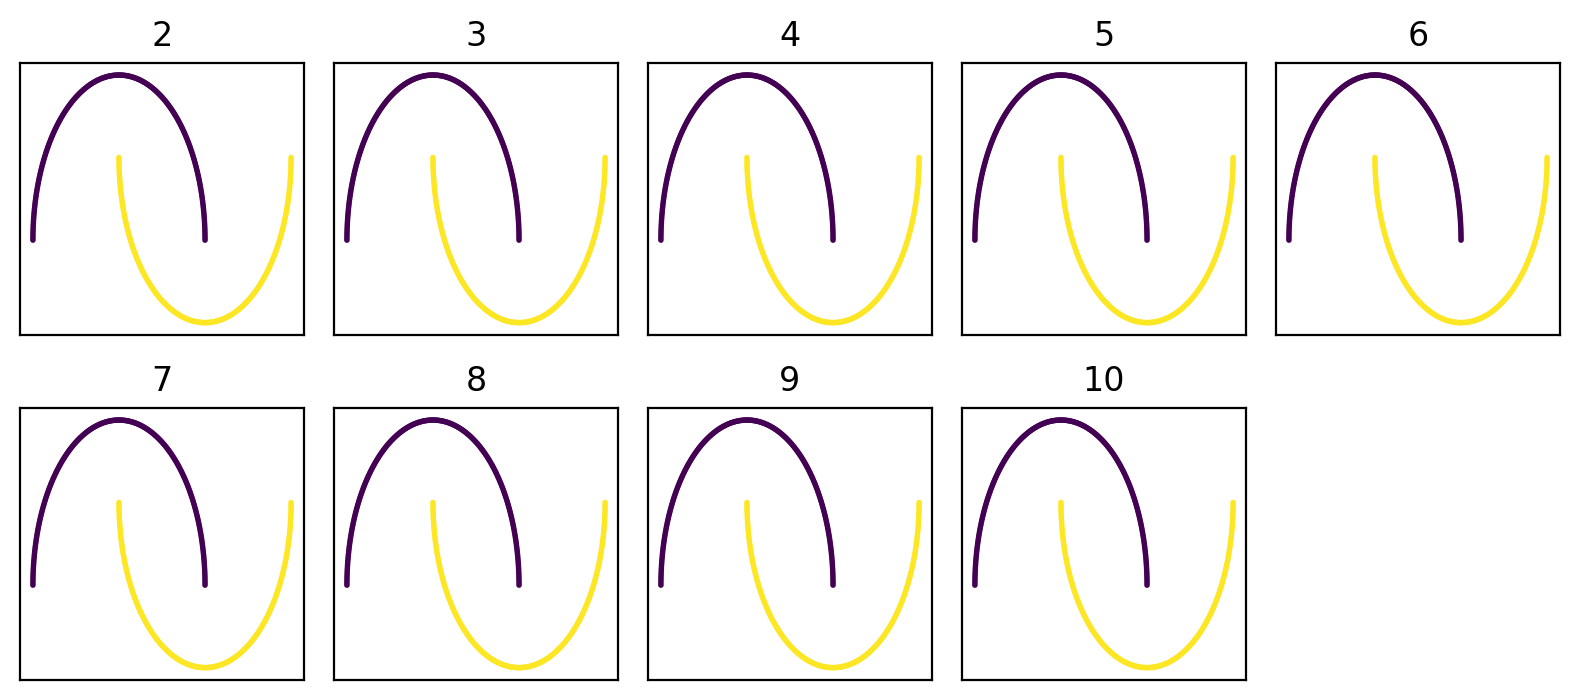

In [3]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

plot_datasets(twoMoons_datasets, n_dims, n_cols=5, figsize=1.6)
plt.savefig("imgs/TwoMoons_dims_data.png")

In [4]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df


eval_results = cache(
    "TwoMoons_dims",
    calc_eval_measures_for_multiple_datasets,
    [twoMoons_datasets, n_dims],
    recalc=False,
)

df = create_and_rescale_df(eval_results)

In [5]:
df = df.rename(columns={"dataset": "n_dims"})
df[(df.measure == "DBCV") & (df.n_dims == 4)]

,n_dims,measure,run,value,time,process_time
281,4,DBCV,0,0.461556,0.163014,0.066226
295,4,DBCV,1,0.461556,0.097555,0.064180
309,4,DBCV,2,0.461556,0.109296,0.062992
323,4,DBCV,3,0.461556,0.143478,0.066277
337,4,DBCV,4,0.461556,0.121666,0.063999
351,4,DBCV,5,0.461556,0.061609,0.060529
365,4,DBCV,6,0.461556,0.111658,0.058988
379,4,DBCV,7,0.461556,0.081926,0.065455
393,4,DBCV,8,0.461556,0.112784,0.067543
407,4,DBCV,9,0.461556,0.074668,0.065846


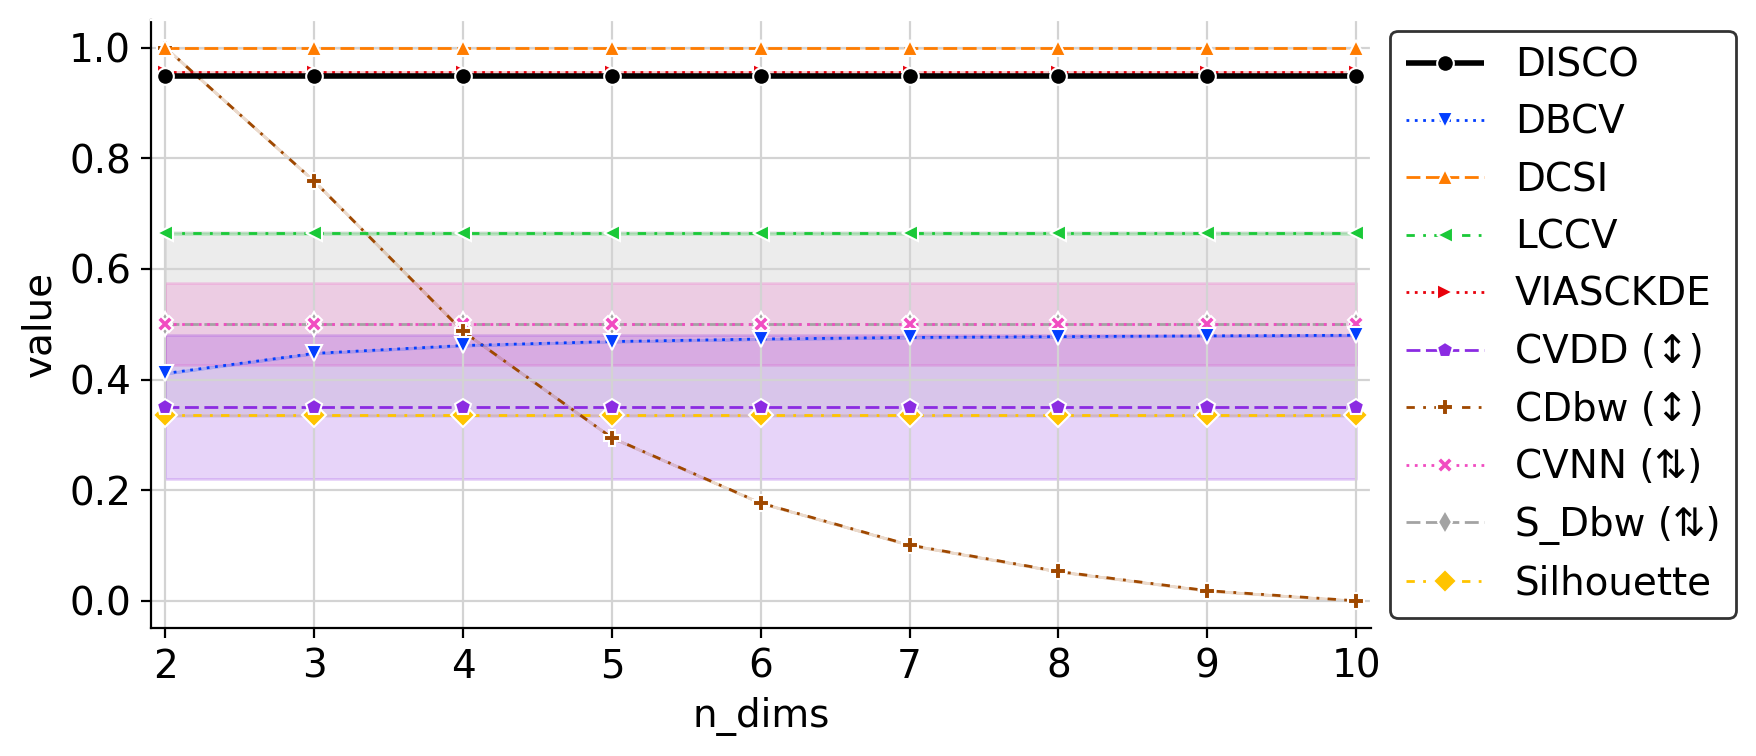

In [6]:
from src.utils.plots import plot_lineplot

eps = 0.1
x_range = n_dims[0] - eps, n_dims[-1] + eps
# df = df.rename(columns={"dataset": "n_dims"})

plot_lineplot(df, "n_dims", "value", "measure", x_range=x_range, y_range=(None, None))
plt.savefig("imgs/TwoMoons_dims.png")

In [36]:
from src.utils.experiments import cache, calc_eval_measures
from src.utils.plots import plot_barplot
from src.utils.metrics import create_and_rescale_df

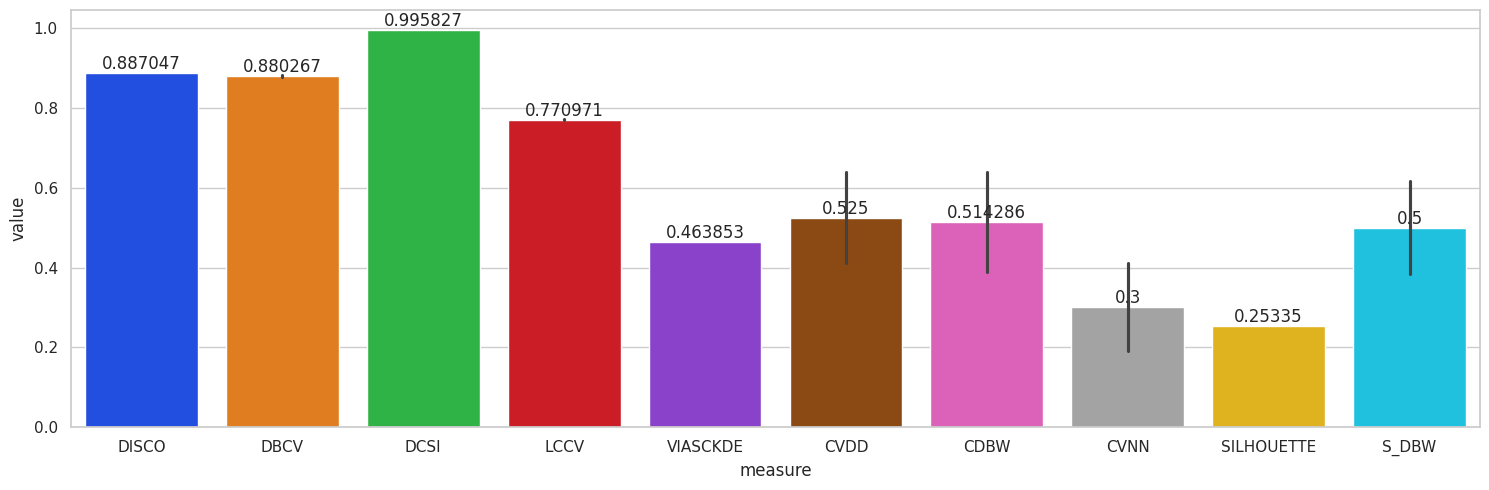

In [37]:
eval_results = cache("S+Rings", calc_eval_measures, [X, l], recalc=False)
df = create_and_rescale_df(eval_results)
plot_barplot(df, "measure", "value", "measure")
plt.show()

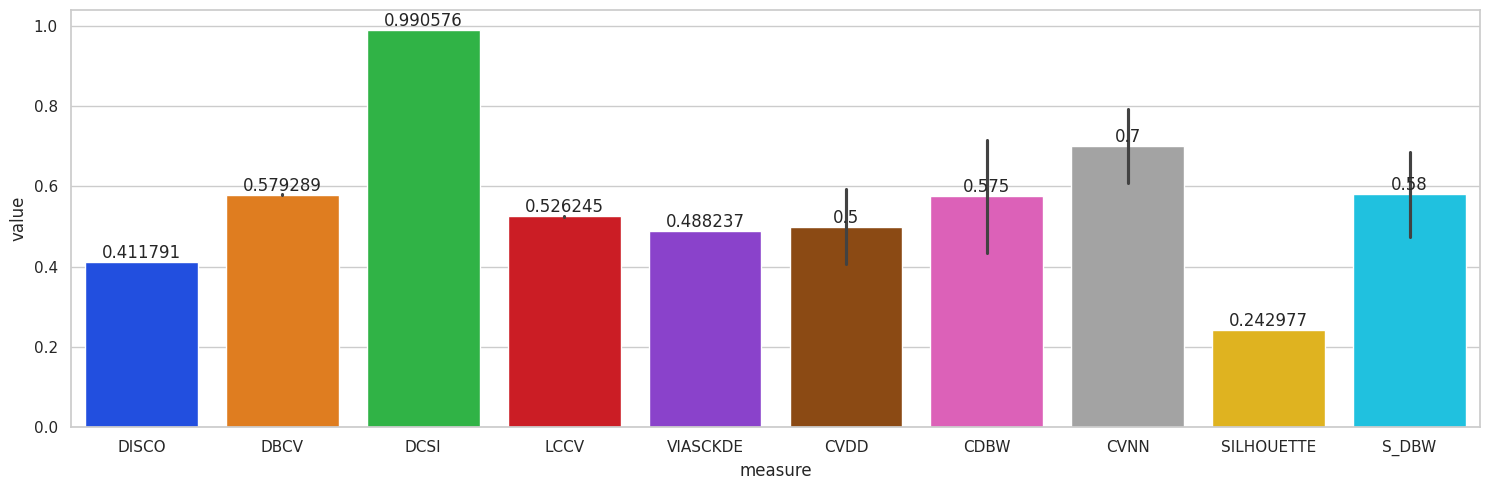

In [38]:
l_ = l.copy()
l_[l_ != -1] = l_[l_ != -1] - 1

eval_results = cache("S+Rings_S_noise", calc_eval_measures, [X, l_], recalc=False)
df = create_and_rescale_df(eval_results)
plot_barplot(df, "measure", "value", "measure")
plt.show()

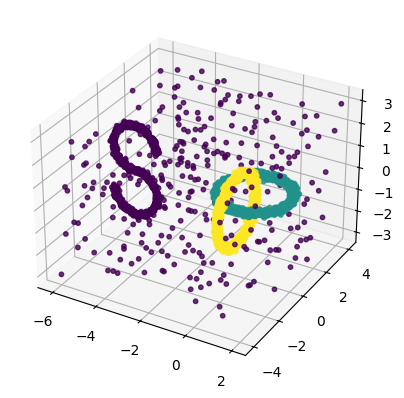

In [39]:
fig = plot_3d_data(X, l_, show_legend=False, show_plot=False)
axes = fig.get_axes()
for ax in axes:
    ax.set_aspect("equal", adjustable="datalim")

plt.show()